In [ ]:
!pip install tbats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tbats import TBATS
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta

# **Kiểm tra tính mùa vụ của các bộ dữ liệu**

**`Bộ dữ liệu giá vàng`**
- Ở biểu đồ ACF ta nhận thấy độ tương quan các độ trễ (lags) hầu như đều là 1, là rất cao, tương quan mạnh ở mọi độ trễ. Như vậy khả năng cao là dữ liệu chuỗi thời gian và có tính mùa vụ, nhưng lại tương quan mạnh ở mọi độ trễ nên khả năng có tính mùa vụ là không và cần thử nghiệm với các chu kỳ đáng chú ý (Seasonal period)

- Ở biểu đồ PACF thì AR = 1 (tự hồi quy bậc nhất) là có tương quan mạnh, sau đó thì độ tương quan giảm với các bậc cao hơn. Như vậy ta chọn use_trend = true.

- Nhìn vào biểu độ giá có sự biến động mạnh qua thời gian và nhìn chung có xu hướng tăng. Như vậy ta chọn use_arma_errors = true.

- Ở biểu đồ thể hiện sai số thì từ năm 2018 đến đầu năm 2020, sai số ở mức trung bình nhưng sau đó thì tăng và biến động dẫn đến không ổn định. Như vậy, ta chọn use_box_cox = true để ổn định lại.


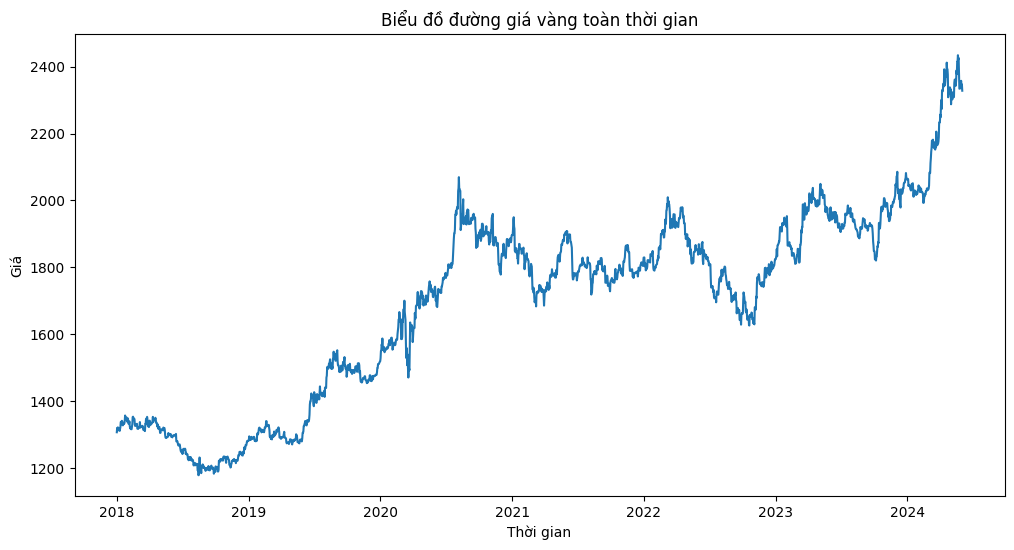

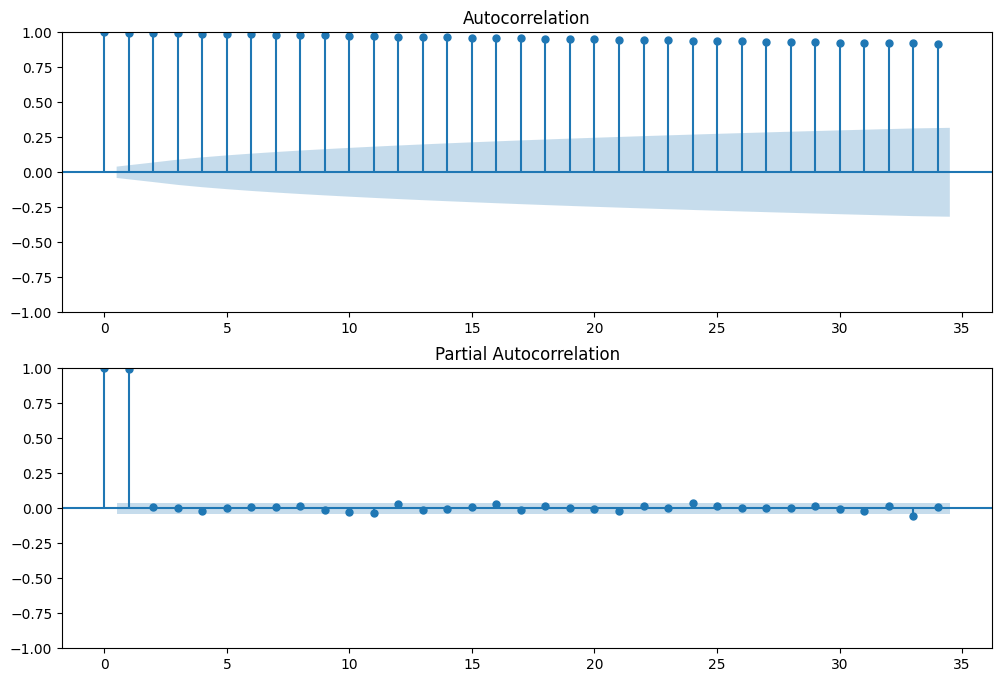

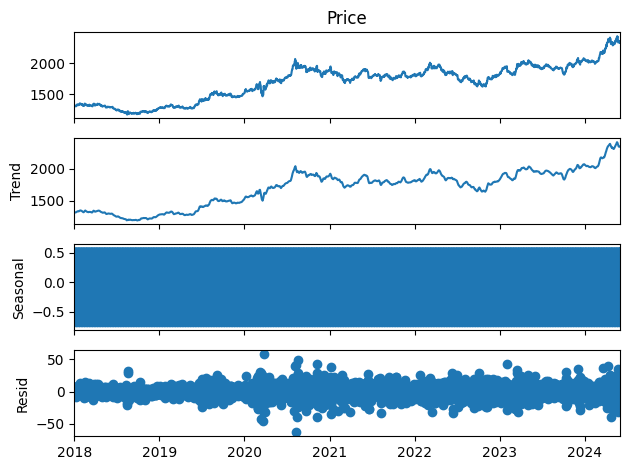

In [ ]:
df_gold = pd.read_csv(r'/content/gold_price_2018_2024.csv', parse_dates=['Date'], index_col='Date')

df_gold.columns = ['Price']
plt.figure(figsize=(12, 6))
plt.plot(df_gold['Price'])
plt.title('Biểu đồ đường giá vàng toàn thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.show()

# ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_gold['Price'], ax=ax[0])
plot_pacf(df_gold['Price'], ax=ax[1])
plt.show()

# Seasonal decomposition
result = seasonal_decompose(df_gold['Price'], model='additive')
result.plot()
plt.show()


**Bộ dữ liệu giá bạch kim**
- Các biểu đồ có sự biến động mạnh như giá vàng. Như vậy các thông số thiết lập như giá vàng.

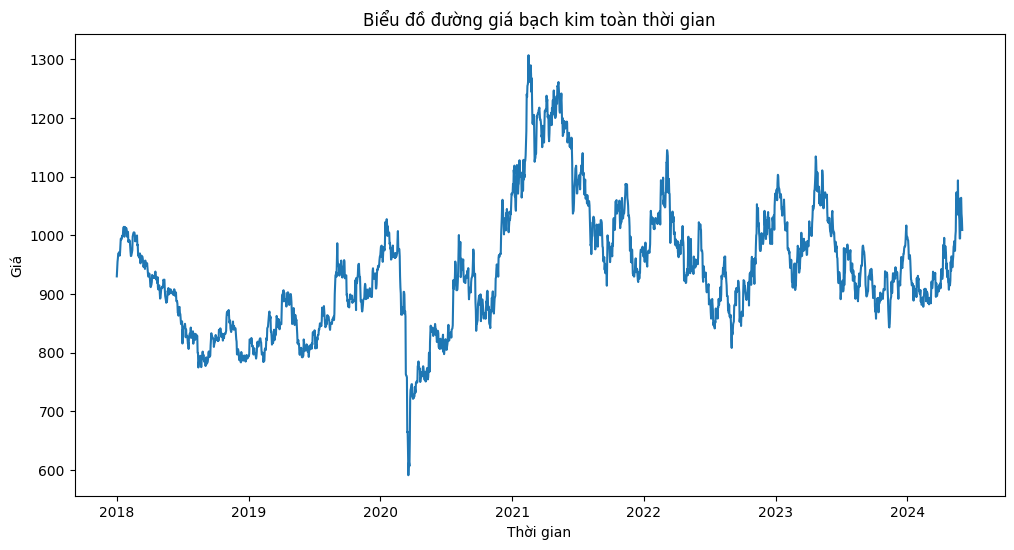

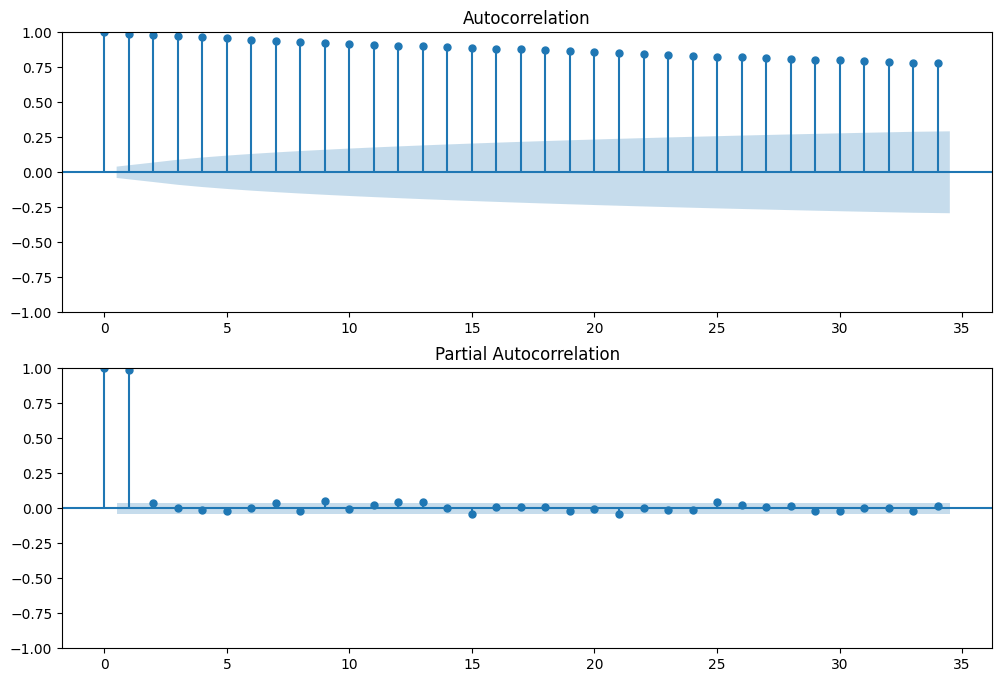

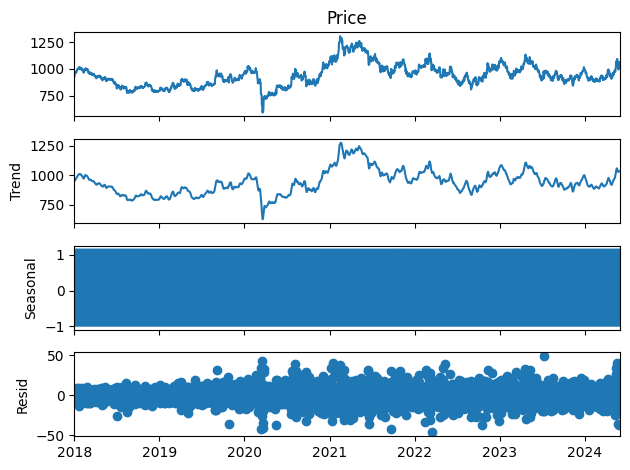

In [ ]:
df_platium = pd.read_csv(r'/content/platium_price_2018_2024.csv', parse_dates=['Date'], index_col='Date')

df_platium.columns = ['Price']
plt.figure(figsize=(12, 6))
plt.plot(df_platium['Price'])
plt.title('Biểu đồ đường giá bạch kim toàn thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.show()

# ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_platium['Price'], ax=ax[0])
plot_pacf(df_platium['Price'], ax=ax[1])
plt.show()

# Seasonal decomposition
result = seasonal_decompose(df_platium['Price'], model='additive')
result.plot()
plt.show()


**Bộ dữ liệu giá bạc**
- Các biểu đồ có biến động gần giống giá vàng nhưng biểu đồ ACF của giá bạc ở các độ trễ cuối có tương quan yếu hơn so với giá vàng nhưng vẫn cáo ở mức 0.8
- Biểu đồ biểu diễn sai số có mức biến động khá thấp vào ổn định từ năm 2018 đến đầu năm 2020 nhưng về sau có sự biến động lớn và không ổn định.
- Tuy vậy, nhìn chung các biểu đồ cũng mang các đặc điểm như giá vàng nên ta thiết lập thông số hàm tbats như giá vàng.

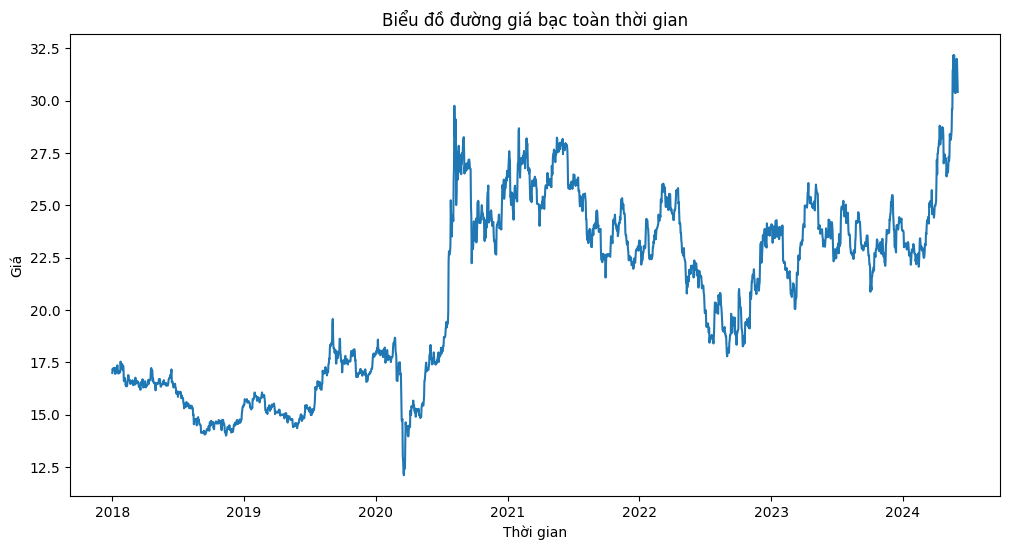

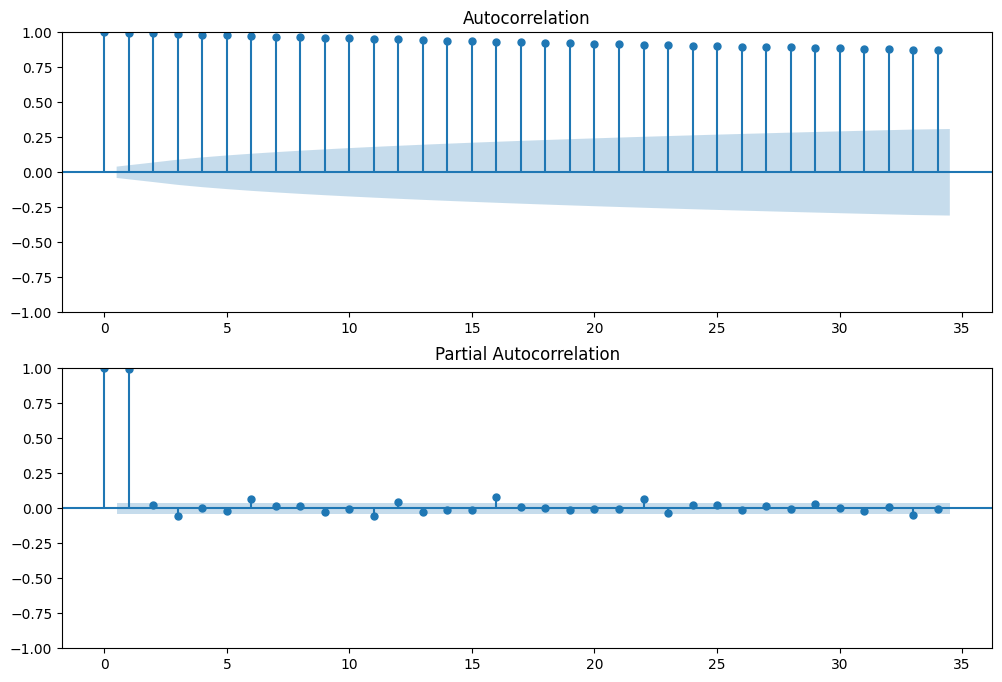

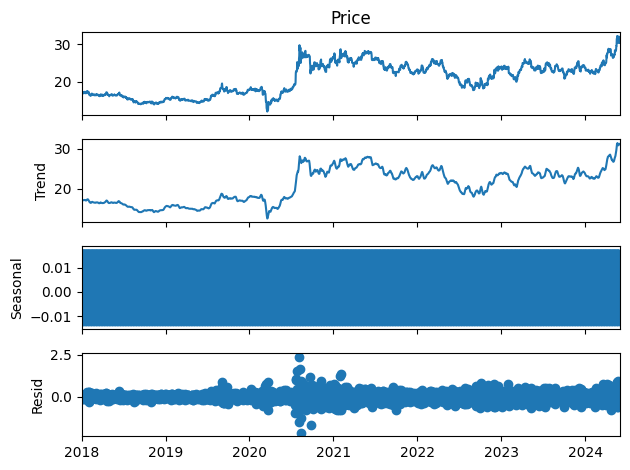

In [ ]:
df_silver = pd.read_csv(r'/content/silver_price_2018_2024.csv', parse_dates=['Date'], index_col='Date')

df_silver.columns = ['Price']
plt.figure(figsize=(12, 6))
plt.plot(df_silver['Price'])
plt.title('Biểu đồ đường giá bạc toàn thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.show()

# ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_silver['Price'], ax=ax[0])
plot_pacf(df_silver['Price'], ax=ax[1])
plt.show()

# Seasonal decomposition
result = seasonal_decompose(df_silver['Price'], model='additive')
result.plot()
plt.show()


# **Thực hiện thuật toán theo tỉ lệ 8:2 (80% train : 20% test)**

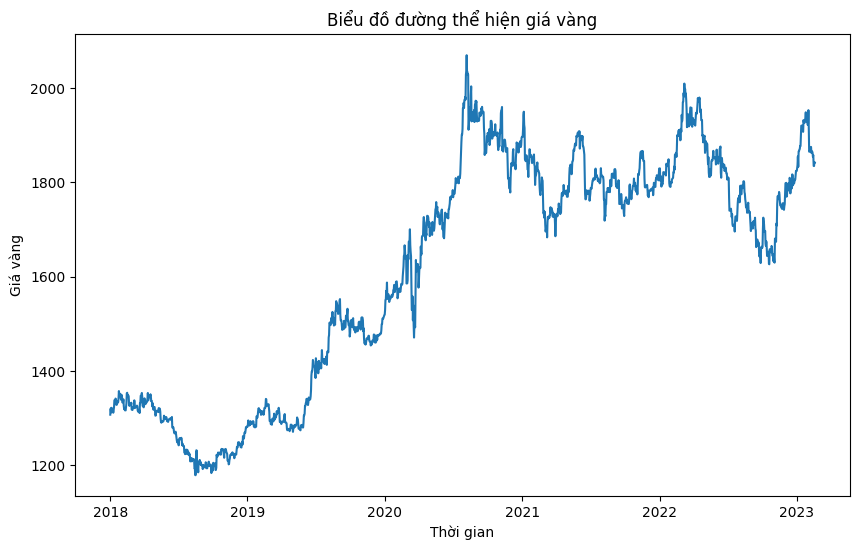

In [ ]:
df_gold = pd.read_csv(r'/content/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold['Day Number'] = df_gold['Date'].rank(method='dense').astype(int)
df_gold.columns = ['Date', 'Price', 'Day Number']

train_size = int(0.8 * len(df_gold))
test_size = len(df_gold) - train_size
train_data_gold = df_gold.iloc[:train_size]
test_data_gold = df_gold.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_gold['Date'], train_data_gold['Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng')
plt.show()

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử các giá trị như 7 ngày, 90, 365, 200, 249, 251, 500, 250 ngày đều là đường thẳng tăng
# Kiểm định không có tính mùa vụ ta được RMSE: 99.8635 , MAPE: 3.5411 %, MAE: 74.4410

test_data_gold = df_gold.iloc[train_size:]
estimator = TBATS(
    #  seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_gold['Price'])

forecast = model.forecast(steps=test_size)

test_data_gold.insert(1, "Price Predict", forecast)

In [ ]:
last_day_number = (df_gold['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_3):])


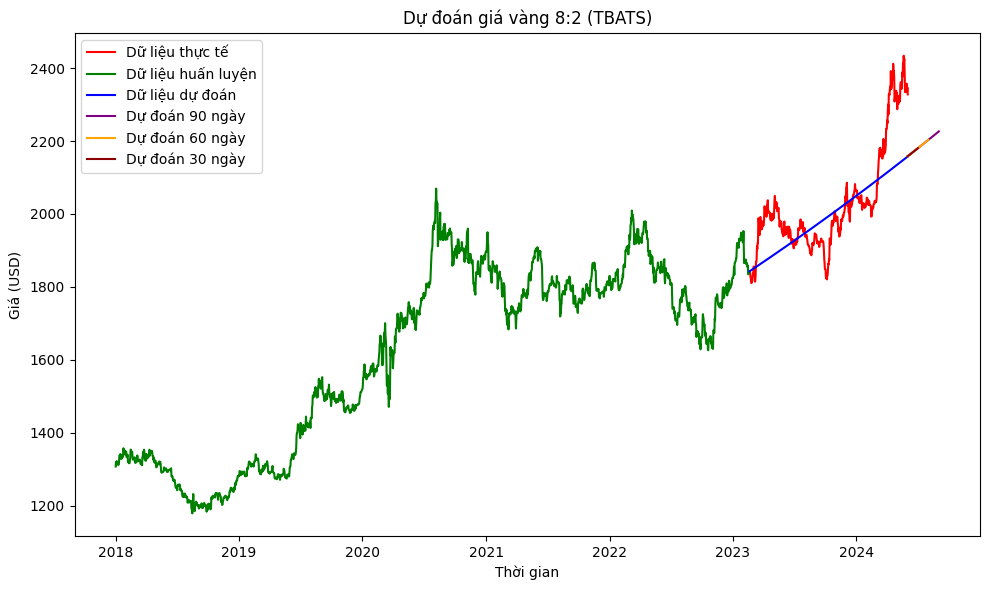

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(test_data_gold['Date'], test_data_gold['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_gold['Date'], train_data_gold['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_gold['Date'], test_data_gold['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá vàng 8:2 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

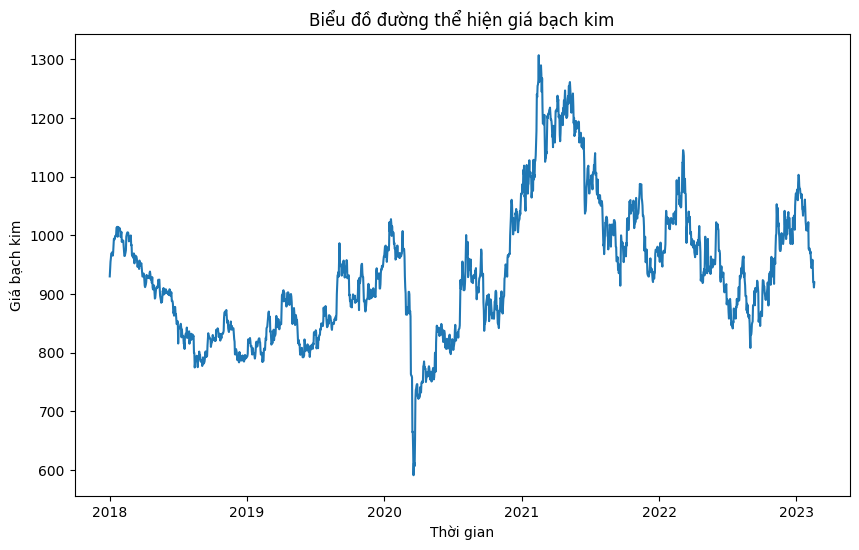

In [ ]:
df_platium = pd.read_csv(r'/content/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_platium.columns = ['Date', 'Price', 'Day Number']

train_data_platium = df_platium.iloc[:train_size]
test_data_platium = df_platium.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_platium['Date'], train_data_platium['Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Thời gian')
plt.ylabel('Giá bạch kim')
plt.show()

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 125, 200 ngày ko đều có kết quả là đường thẳng ngang, 250 ngày là dường cong
# Như vậy, nhận thấy dữ liệu không có tính mùa vụ, đường thẳng dự báo ra kết quả khả quan hơn
test_data_platium = df_platium.iloc[train_size:]
estimator = TBATS(
#     seasonal_periods=[365],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_platium['Price'])


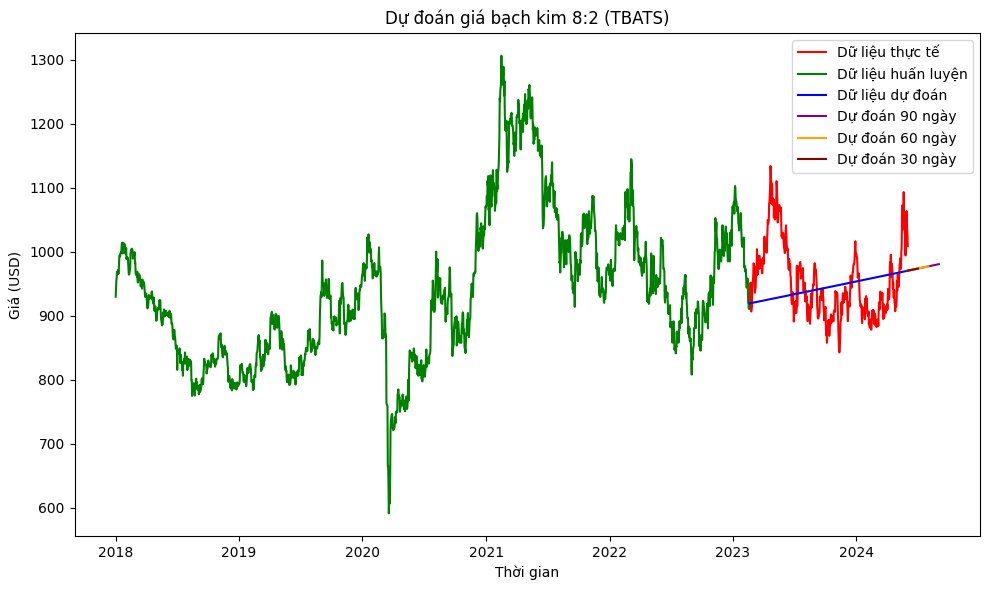

In [ ]:
forecast = model.forecast(steps=test_size)

test_data_platium.insert(1, "Price Predict", forecast)

last_day_number = (df_platium['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_platium['Date'], test_data_platium['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_platium['Date'], train_data_platium['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_platium['Date'], test_data_platium['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạch kim 8:2 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

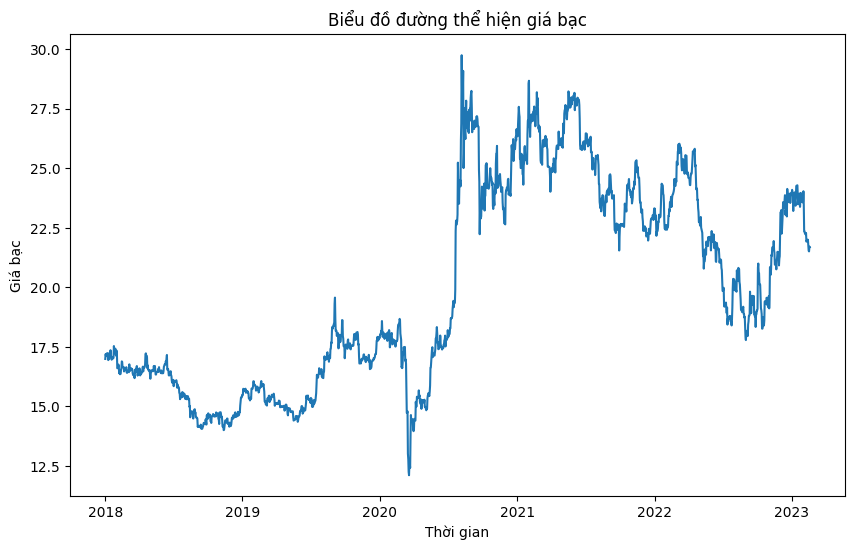

In [ ]:
df_silver = pd.read_csv(r'/content/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_platium['Date'])
df_silver['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_silver.columns = ['Date', 'Price', 'Day Number']

train_data_silver = df_silver.iloc[:train_size]
test_data_silver = df_silver.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_silver['Date'], train_data_silver['Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Thời gian')
plt.ylabel('Giá bạc')
plt.show()

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 200, 250 ngày đều là đường thẳng tăng,
# Như vậy, dữ liệu không có tính mùa vụ, đường thẳng tăng cho ra kết quả khả quan hơn
test_data_silver = df_silver.iloc[train_size:]
estimator = TBATS(
#     seasonal_periods=[30],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_silver['Price'])


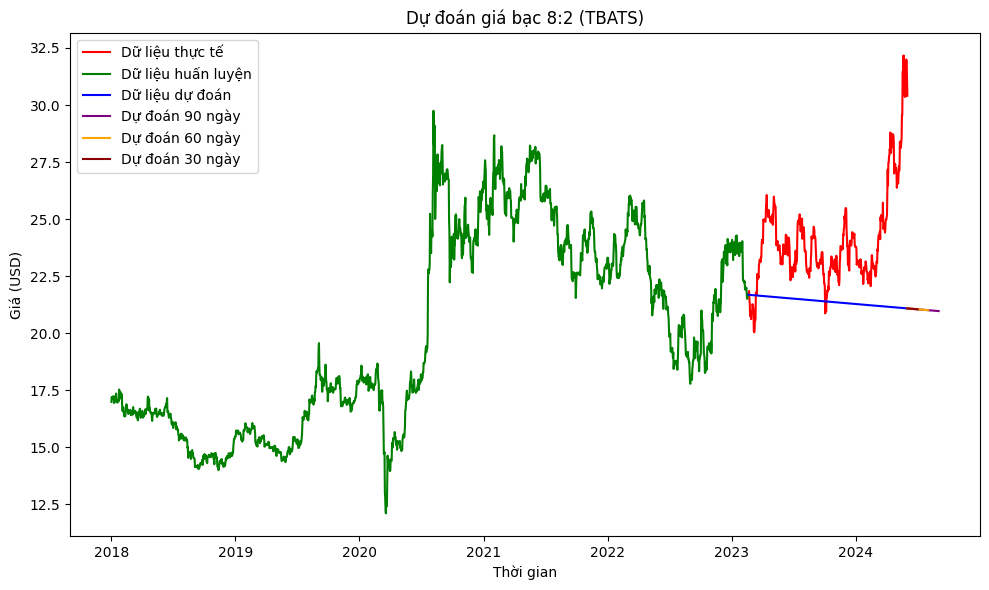

In [ ]:
forecast = model.forecast(steps=test_size)

test_data_silver.insert(1, "Price Predict", forecast)

last_day_number = (df_silver['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_silver['Date'], test_data_silver['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_silver['Date'], train_data_silver['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_silver['Date'], test_data_silver['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạc 8:2 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_data_gold['Price'].values
predict_gold = test_data_gold['Price Predict'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 99.86346839760184
MAPE: 3.541087503750459%
MAE: 74.44102301262551


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_data_platium['Price'].values
predict_platium = test_data_platium['Price Predict'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 63.98587863864196
MAPE: 5.209114947935191%
MAE: 50.71615355659872


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_data_silver['Price'].values
predict_silver = test_data_silver['Price Predict'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 3.500761037419699
MAPE: 11.008128514175553%
MAE: 2.796197362607502


# **Thực hiện thuật toán theo tỉ lệ 7:3 (70% train : 30% test)**

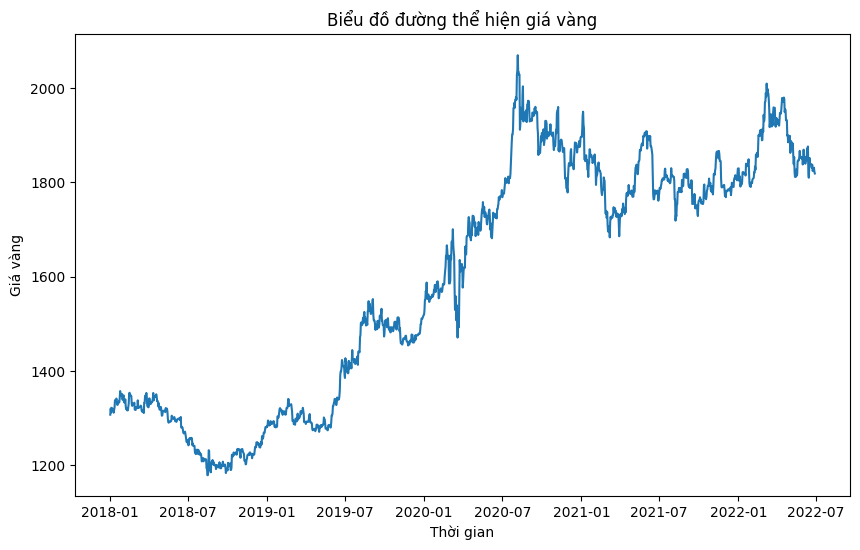

In [ ]:
df_gold = pd.read_csv(r'/content/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold['Day Number'] = df_gold['Date'].rank(method='dense').astype(int)
df_gold.columns = ['Date', 'Price', 'Day Number']

train_size = int(0.7 * len(df_gold))
test_size = len(df_gold) - train_size
train_data_gold = df_gold.iloc[:train_size]
test_data_gold = df_gold.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_gold['Date'], train_data_gold['Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng')
plt.show()



In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử các giá trị như 7 ngày, 90, 365, 200, 249, 251, 500, 250 ngày đều là đường thẳng tăng
# Như vậy có thể thấy dữ liệu không có tính mùa vụ và đường thẳng có kết quả khả quan hơn
test_data_gold = df_gold.iloc[train_size:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_gold['Price'])




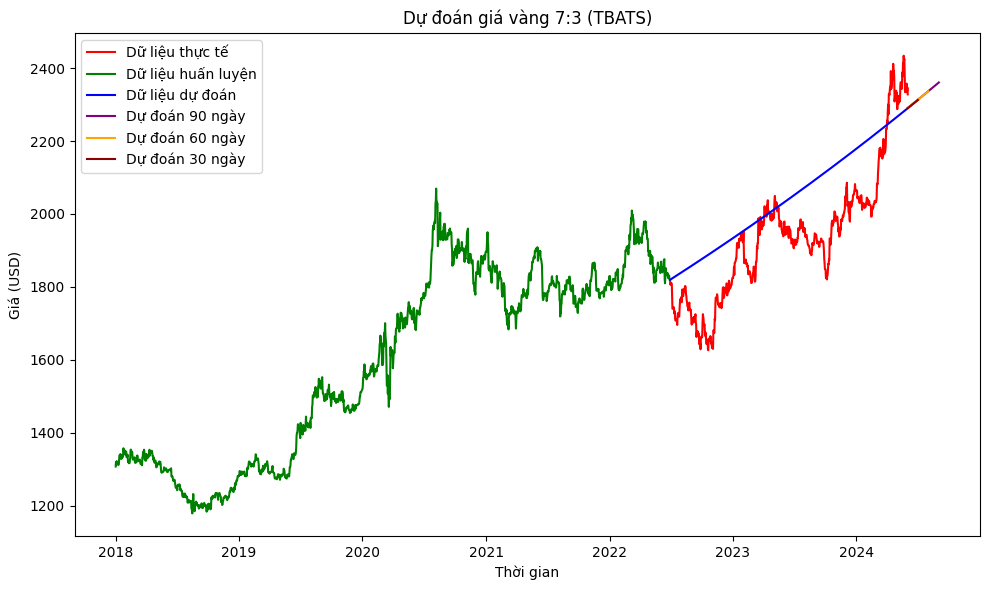

In [ ]:
forecast = model.forecast(steps=test_size)
test_data_gold.insert(1, "Price Predict", forecast)

last_day_number = (df_gold['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number, last_day_number + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_gold['Date'], test_data_gold['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_gold['Date'], train_data_gold['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_gold['Date'], test_data_gold['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá vàng 7:3 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

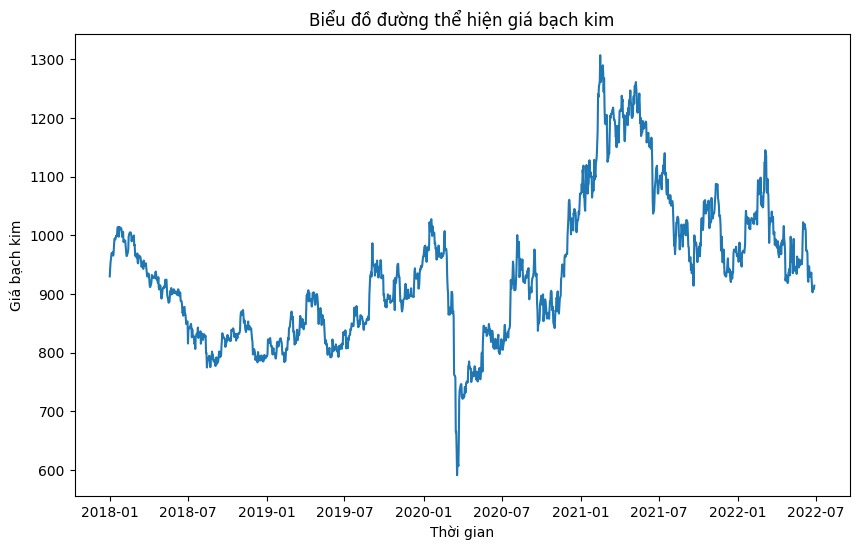

In [ ]:
df_platium = pd.read_csv(r'/content/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_platium.columns = ['Date', 'Price', 'Day Number']

train_data_platium = df_platium.iloc[:train_size]
test_data_platium = df_platium.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_platium['Date'], train_data_platium['Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Thời gian')
plt.ylabel('Giá bạch kim')
plt.show()

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 50, 90, 100, 125 ngày đều có kết quả là đường thẳng ngang, 365 ngày là dường cong giống với Test, 200 ngày quá cong, 250 ngày cong nhẹ
# Kiểm định ta được 365 có RMSE: 65.1698, MAPE: 5.6282 %, MAE: 53.3321
# Kiểm định ta được 200 có RMSE: 61.8399 , MAPE: 5.0120 %, MAE: 48.7536
# Kiểm định ta được 250 có RMSE: 66.5910 , MAPE: 5.5762 %, MAE: 53.7436
# Kiểm định không có tính mùa vụ ta được RMSE: 71.6050 , MAPE: 5.4045 %, MAE: 53.6054
# Từ kết quả kiểm định ta có thể thấy với mùa vụ 200 ngày thì cho ra kết quả khả quan nhất

# Sau đó xét chu kỳ 200 ngày, tham số thứ 2 (chù kỳ thứ 2) mặc định là 7, ta tiếp tục kiểm định mùa vụ
# Kiểm định ta được 200,30 có RMSE: 61.4099, MAPE: 5.0193 %, MAE: 48.6984
# Kiểm định ta được 200,40 có RMSE: 61.1847, MAPE: 5.0171 %, MAE: 48.4798
# Kiểm định ta được 200,50 có RMSE: 61.4832, MAPE: 4.9657 %, MAE: 48.3024
# Kiểm định ta được 200,70 có RMSE: 63.2805, MAPE: 4.9848 %, MAE: 48.9724
# Kiểm định ta được 200,100 có RMSE: 61.3381, MAPE: 4.9852 %, MAE: 48.3891

# Như vậy, các chu kỳ phù hợp là 200, 50

test_data_platium = df_platium.iloc[train_size:]
estimator = TBATS(
     seasonal_periods=[200,50],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_platium['Price'])


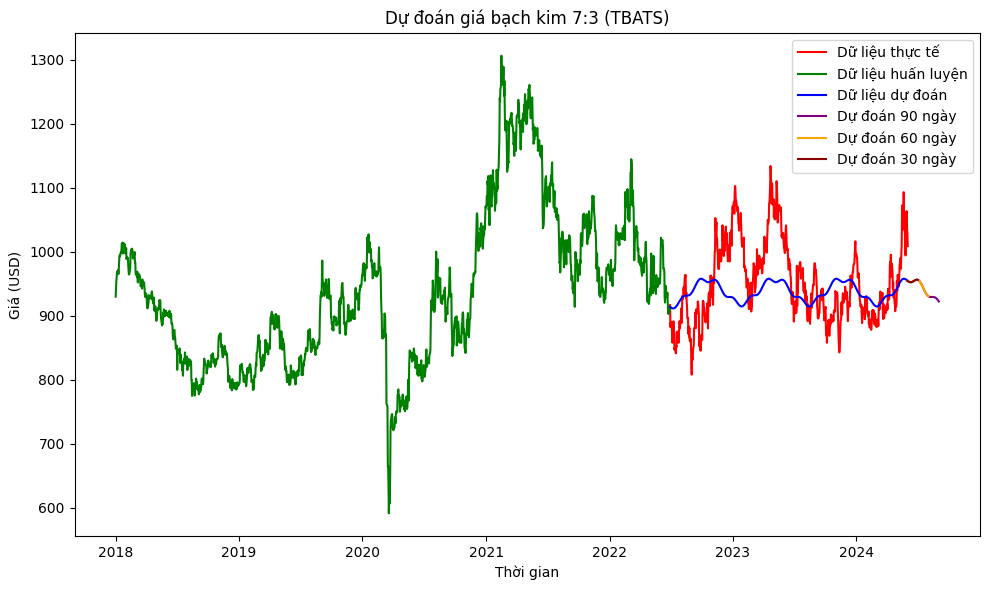

In [ ]:
forecast = model.forecast(steps=test_size)

test_data_platium.insert(1, "Price Predict", forecast)

last_day_number = (df_platium['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_platium['Date'], test_data_platium['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_platium['Date'], train_data_platium['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_platium['Date'], test_data_platium['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạch kim 7:3 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

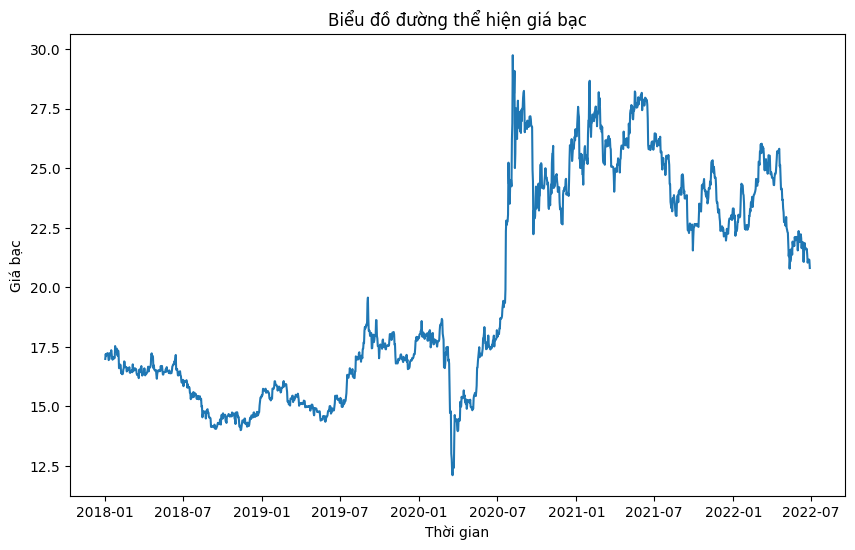

In [ ]:
df_silver = pd.read_csv(r'/content/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
df_silver['Day Number'] = df_silver['Date'].rank(method='dense').astype(int)
df_silver.columns = ['Date', 'Price', 'Day Number']

train_data_silver = df_silver.iloc[:train_size]
test_data_silver = df_silver.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_silver['Date'], train_data_silver['Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Thời gian')
plt.ylabel('Giá bạc')
plt.show()

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 200, 250 ngày đều là đường thẳng tăng
# Như vậy, dữ liệu không có tính mùa vụ


test_data_silver = df_silver.iloc[train_size:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_silver['Price'])


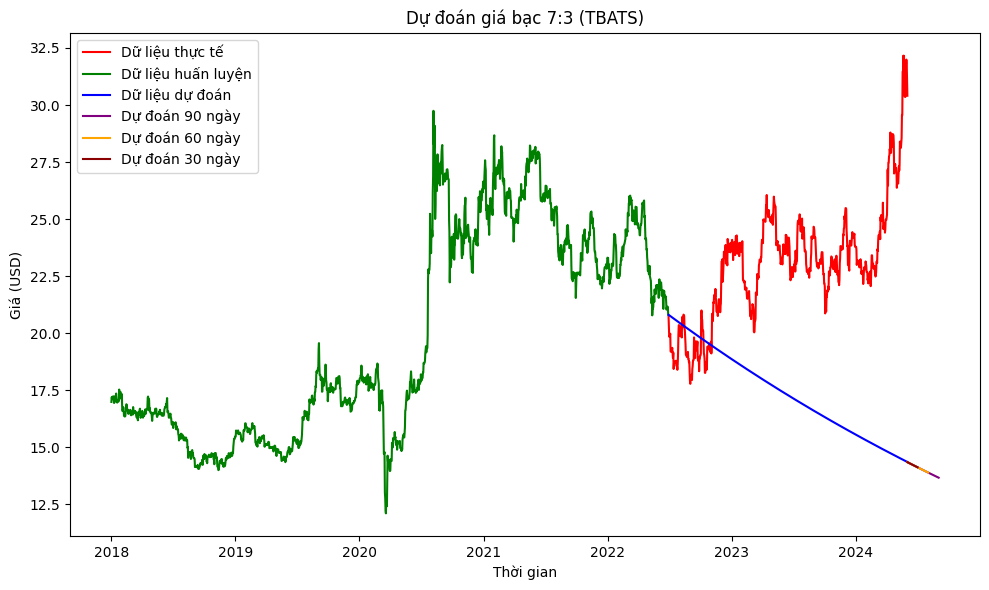

In [ ]:
forecast = model.forecast(steps=test_size)

test_data_silver.insert(1, "Price Predict", forecast)

last_day_number = (df_silver['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_silver['Date'], test_data_silver['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_silver['Date'], train_data_silver['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_silver['Date'], test_data_silver['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạc 7:3 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_data_gold['Price'].values
predict_gold = test_data_gold['Price Predict'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 136.5471965829937
MAPE: 6.356748150415292%
MAE: 119.97467619992653


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_data_platium['Price'].values
predict_platium = test_data_platium['Price Predict'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 61.48324334403013
MAPE: 4.965713933655269%
MAE: 48.302400865178534


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_data_silver['Price'].values
predict_silver = test_data_silver['Price Predict'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 6.9954572262410295
MAPE: 24.60809714366417%
MAE: 5.964669311501478


# **Thực hiện thuật toán theo tỉ lệ 9:1 (90% train : 10% test)**

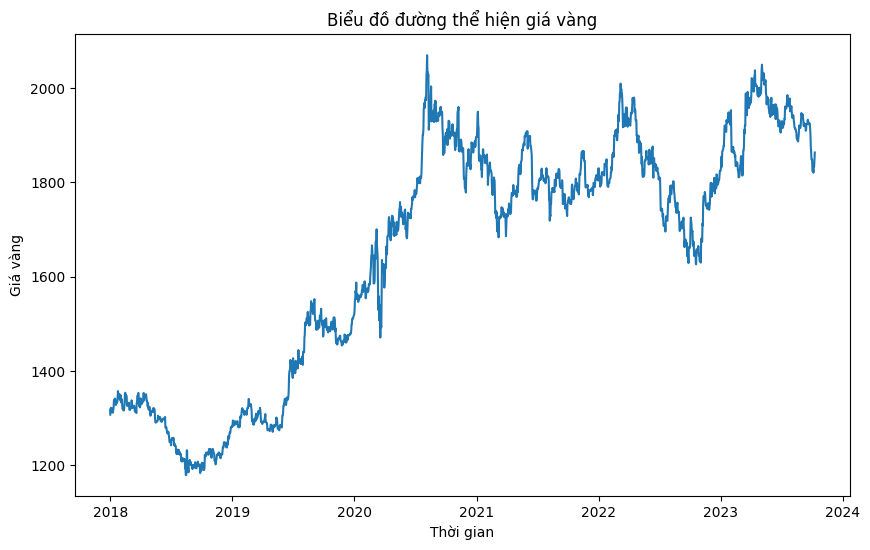

In [ ]:
df_gold = pd.read_csv(r'/content/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold['Day Number'] = df_gold['Date'].rank(method='dense').astype(int)
df_gold.columns = ['Date', 'Price', 'Day Number']

train_size = int(0.9 * len(df_gold))
test_size = len(df_gold) - train_size
train_data_gold = df_gold.iloc[:train_size]
test_data_gold = df_gold.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_gold['Date'], train_data_gold['Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng')
plt.show()


In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử các giá trị như 7 ngày, 90, 365, 200, 249, 251, 500, 250 ngày đều là đường thẳng tăng
# Như vậy có thể thấy dữ liệu không có tính mùa vụ
test_data_gold = df_gold.iloc[train_size:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_gold['Price'])


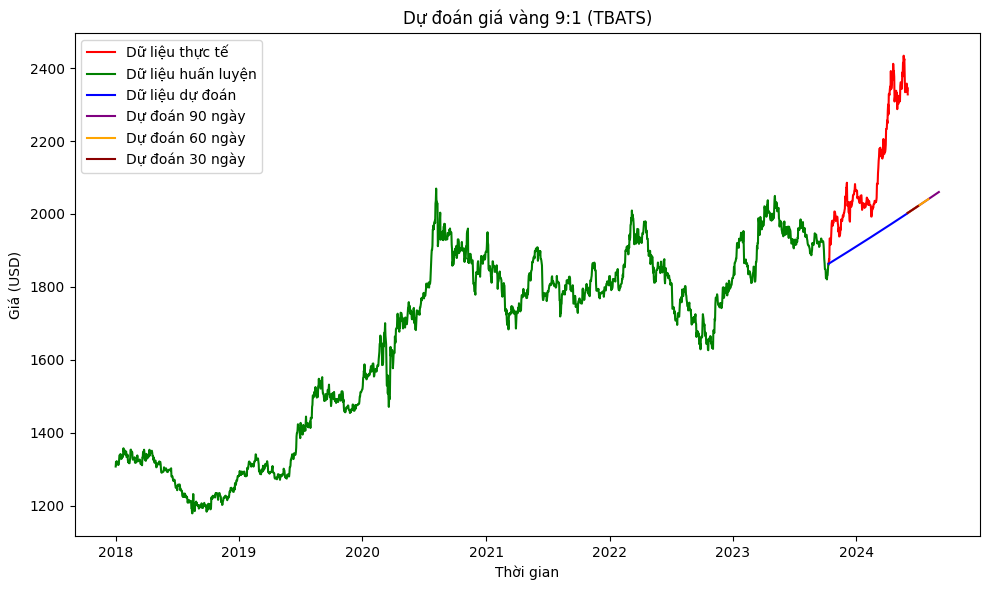

In [ ]:
forecast = model.forecast(steps=test_size)

test_data_gold.insert(1, "Price Predict", forecast)

last_day_number = (df_gold['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_gold['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_gold['Date'], test_data_gold['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_gold['Date'], train_data_gold['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_gold['Date'], test_data_gold['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá vàng 9:1 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

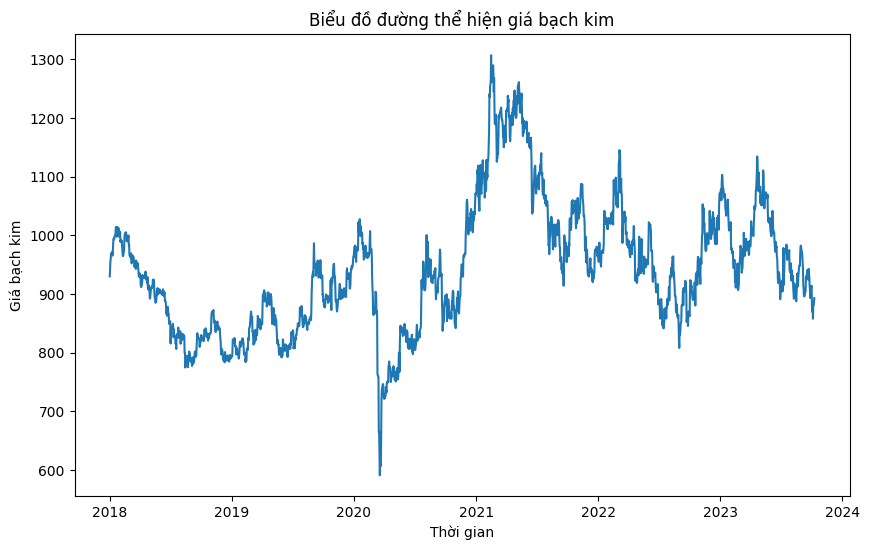

In [ ]:
df_platium = pd.read_csv(r'/content/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_platium.columns = ['Date', 'Price', 'Day Number']

train_data_platium = df_platium.iloc[:train_size]
test_data_platium = df_platium.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_platium['Date'], train_data_platium['Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Thời gian')
plt.ylabel('Giá bạch kim')
plt.show()

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 125, 200, 250 ngày đều có kết quả là đường thẳng ngang
# Như vậy có thể thấy dữ liệu không có tính mùa vụ

test_data_platium = df_platium.iloc[train_size:]
estimator = TBATS(
    #  seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_platium['Price'])


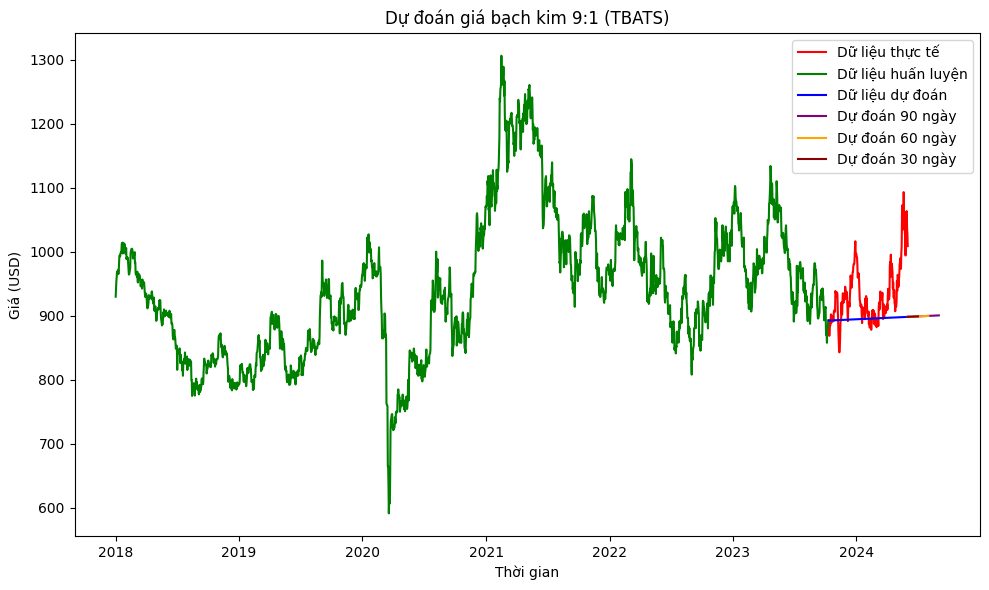

In [ ]:
forecast = model.forecast(steps=test_size)

test_data_platium.insert(1, "Price Predict", forecast)

last_day_number = (df_platium['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_platium['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_platium['Date'], test_data_platium['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_platium['Date'], train_data_platium['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_platium['Date'], test_data_platium['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạch kim 9:1 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

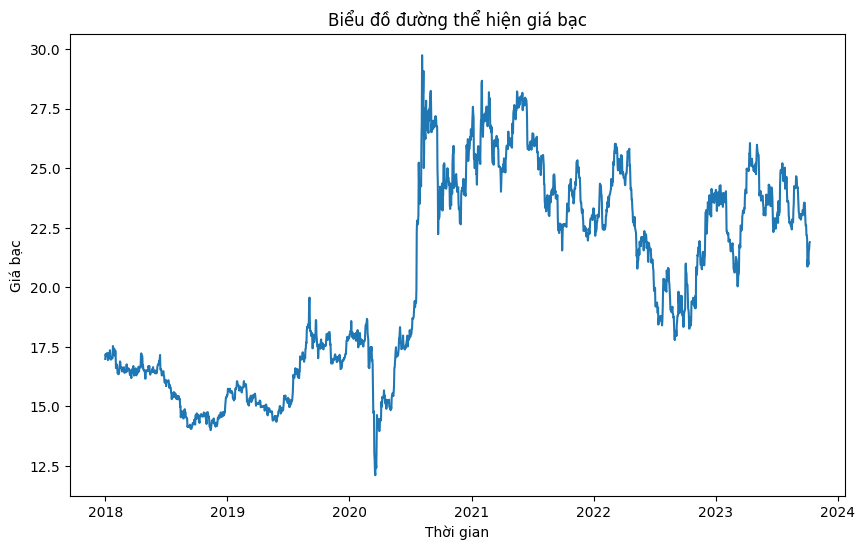

In [ ]:
df_silver = pd.read_csv(r'/content/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
df_silver['Day Number'] = df_silver['Date'].rank(method='dense').astype(int)
df_silver.columns = ['Date', 'Price', 'Day Number']

train_data_silver = df_silver.iloc[:train_size]
test_data_silver = df_silver.iloc[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_silver['Date'], train_data_silver['Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Thời gian')
plt.ylabel('Giá bạc')
plt.show()

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 250 ngày đều là đường thẳng tăng, 50, 100, 200 ngày là đường cong
# Kiểm định ta được 50 có RMSE: 3.6790 , MAPE: 10.0941 %, MAE: 2.7040
# Kiểm định ta được 100 có RMSE: 3.6060 , MAPE: 9.6723 %, MAE: 2.6007
# Kiểm định ta được 200 có RMSE: 3.7468 , MAPE: 10.4241 %, MAE: 2.7849
# Kiểm định không có tính mùa vụ ta được RMSE: 3.8143 , MAPE: 10.7732 %, MAE: 2.8722
# Như vậy, dữ liệu với chu kỳ 100 ngày cho ra kết quả khả quan hơn

# Sau đó xét chu kỳ 100 ngày, tham số thứ 2 (chu kỳ thứ 2) mặc định là 7, ta tiếp tục kiểm định mùa vụ
# Kiểm định ta được 100,30 có RMSE: 3.6278 , MAPE: 9.7816 %, MAE: 2.6278
# Kiểm định ta được 100,40 có RMSE: 3.6798 , MAPE: 10.0767 %, MAE: 2.7001
# Kiểm định ta được 100,50 có RMSE: 3.6036 , MAPE: 9.6583 %, MAE: 2.5972
# Kiểm định ta được 100,70 có RMSE: 3.6300 , MAPE: 9.8324 %, MAE: 2.6394

# Như vậy, các chu kỳ phù hợp là 100, 50


test_data_silver = df_silver.iloc[train_size:]
estimator = TBATS(
    seasonal_periods=[100,50],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_silver['Price'])


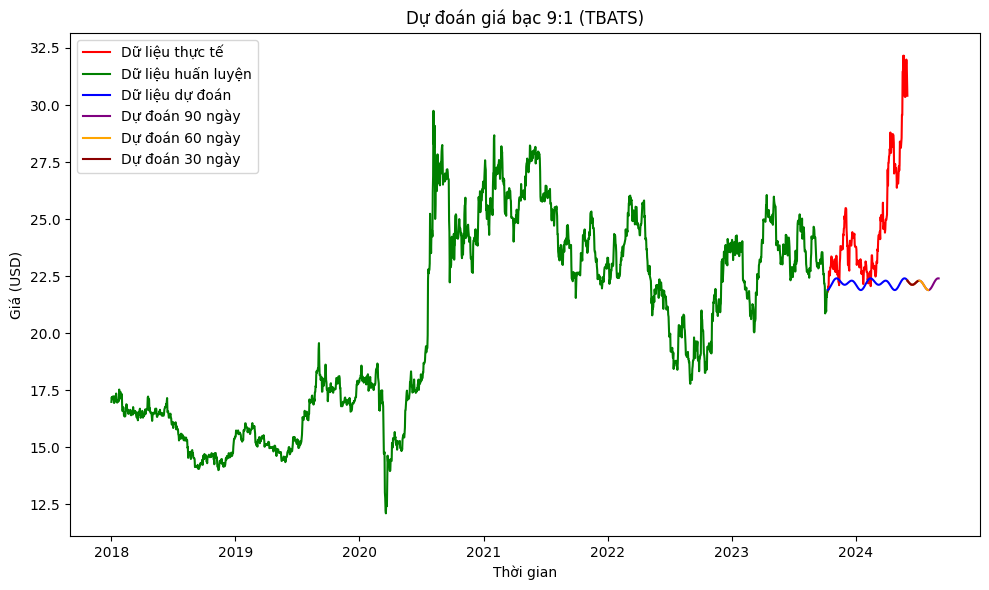

In [ ]:
forecast = model.forecast(steps=test_size)

test_data_silver.insert(1, "Price Predict", forecast)

last_day_number = (df_silver['Day Number'].max())

# Dự đoán từ 01/06/2024 đến 01/07/2024 (31 ngày)
future_dates_1 = pd.date_range(start='2024-06-01', end='2024-07-01')
future_day_numbers_1 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_1))
future_data_1 = pd.DataFrame({'Date': future_dates_1, 'Day Number': future_day_numbers_1})
future_data_1.insert(1, "Price Predict",  (model.forecast(steps=(future_data_1['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_1):])

# Dự đoán từ 01/06/2024 đến 01/08/2024 (62 ngày)
future_dates_2 = pd.date_range(start='2024-06-01', end='2024-08-01')
future_day_numbers_2 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_2))
future_data_2 = pd.DataFrame({'Date': future_dates_2, 'Day Number': future_day_numbers_2})
future_data_2.insert(1, "Price Predict",  (model.forecast(steps=(future_data_2['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_2):])

# Dự đoán từ 01/06/2024 đến 01/09/2024 (93 ngày)
future_dates_3 = pd.date_range(start='2024-06-01', end='2024-09-01')
future_day_numbers_3 = range(last_day_number + 1, last_day_number + 1 + len(future_dates_3))
future_data_3 = pd.DataFrame({'Date': future_dates_3, 'Day Number': future_day_numbers_3})
future_data_3.insert(1, "Price Predict",  (model.forecast(steps=(future_data_3['Day Number'].iloc[-1] - train_data_silver['Day Number'].iloc[-1])))[-len(future_dates_3):])


plt.figure(figsize=(10, 6))

plt.plot(test_data_silver['Date'], test_data_silver['Price'], label='Dữ liệu thực tế', color='red')
plt.plot(train_data_silver['Date'], train_data_silver['Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(test_data_silver['Date'], test_data_silver['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data_3['Date'], future_data_3['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data_2['Date'], future_data_2['Price Predict'], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data_1['Date'], future_data_1['Price Predict'], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạc 9:1 (TBATS)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_data_gold['Price'].values
predict_gold = test_data_gold['Price Predict'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 218.92269601243217
MAPE: 8.496613144305849%
MAE: 186.75338139513394


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_data_platium['Price'].values
predict_platium = test_data_platium['Price Predict'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 58.47374070775399
MAPE: 4.2939955405644845%
MAE: 41.766767748837346


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_data_silver['Price'].values
predict_silver = test_data_silver['Price Predict'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 3.603292687017308
MAPE: 9.657977470555332%
MAE: 2.597131537026215
